In [1]:
import numpy as np
from numba import jit
from typing import List, Tuple

## Helper Functions


In [2]:
@jit(nopython=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    Calculates the sigmoid function for a given input

    Args:
      x: np.ndarray: input to the sigmoid function

    Returns:
      np.ndarray: output of the sigmoid function
    """

    return 1 / (1 + np.exp(-x))


@jit(nopython=True)
def sigmoid_derivative(x: np.ndarray) -> np.ndarray:
    """
    Calculates the derivative of the sigmoid function for a given input

    Args:
      x: np.ndarray: input to the sigmoid function

    Returns:
      np.ndarray: output of the sigmoid function derivative
    """

    return x * (1 - x)


@jit(nopython=True)
def relu(x: np.ndarray) -> np.ndarray:
    """
    Calculates the ReLU function for a given input

    Args:
      x: np.ndarray: input to the ReLU function

    Returns:
      np.ndarray: output of the ReLU function
    """

    return np.maximum(0, x)


@jit(nopython=True)
def relu_derivative(x: np.ndarray) -> np.ndarray:
    """
    Calculates the derivative of the ReLU function for a given input

    Args:
      x: np.ndarray: input to the ReLU function

    Returns:
      np.ndarray: output of the ReLU function derivative
    """

    return np.where(x > 0, 1, 0)

In [3]:
def split_dataset(
    X: np.ndarray,
    y: np.ndarray,
    train_ratio: float = 0.8,
    validation_ratio: float = 0.1,
    test_ratio: float = 0.1,
    random_state: int = 24,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Splits the dataset into training, validation and test sets

    Args:
      X: np.ndarray: input data
      y: np.ndarray: target data
      train_ratio: float: ratio of the training set
      validation_ratio: float: ratio of the validation set
      test_ratio: float: ratio of the test set
      random_state: int: random state for reproducibility

    Returns:
      Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]: training and test data
    """

    assert np.isclose(
        train_ratio + validation_ratio + test_ratio, 1
    ), "Ratios should sum to 1"

    np.random.seed(random_state)

    n: int = X.shape[0]
    indices: np.ndarray = np.random.permutation(n)

    np.random.shuffle(indices)

    train_size: int = int(n * train_ratio)
    validation_size: int = int(n * validation_ratio)

    X_shuffled, y_shuffled = X[indices], y[indices]

    return (
        X_shuffled[:train_size],
        y_shuffled[:train_size],
        X_shuffled[train_size : train_size + validation_size],
        y_shuffled[train_size : train_size + validation_size],
        X_shuffled[train_size + validation_size :],
        y_shuffled[train_size + validation_size :],
    )


def standard_scaler(
    X_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Normalizes the input data using the standard scaler approach (z-score normalization)

    Args:
      X_train: np.ndarray: training data
      X_val: np.ndarray: validation data
      X_test: np.ndarray: test data

    Returns:
      Tuple[np.ndarray, np.ndarray, np.ndarray]: normalized training, validation and test data
    """

    mean: np.ndarray = np.mean(X_train, axis=0)
    std: np.ndarray = np.std(X_train, axis=0)
    std[std == 0] = 1e-8

    return tuple((X - mean) / std for X in (X_train, X_val, X_test))

## Neural Network


In [4]:
from dataclasses import dataclass
from typing import Callable, Dict


@dataclass
class ActivationFunction:
    """
    Activation function dataclass
    """

    function: Callable[[np.ndarray], np.ndarray]
    derivative: Callable[[np.ndarray], np.ndarray]


@dataclass
class Layer:
    """
    Layer dataclass
    """

    weights: np.ndarray
    bias: np.ndarray
    activation_function: ActivationFunction

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


class NeuralNetwork:
    def __init__(self, layer_sizes: List[int], activation: str = "relu"):
        self.layers: List[Layer] = []
        activation_functions = self._get_activation_functions(activation)

        for i in range(len(layer_sizes) - 1):
            weights = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) / np.sqrt(
                layer_sizes[i]
            )

            bias = np.zeros(layer_sizes[i + 1])
            self.layers.append(Layer(weights, bias, activation_functions))

    def _get_activation_functions(self, activation: str) -> ActivationFunction:
        """
        Returns the activation function and its derivative

        Args:
          activation: str: activation function

        Returns:
          ActivationFunction: activation function and its derivative
        """

        if activation == "relu":
            return ActivationFunction(relu, relu_derivative)

        elif activation == "sigmoid":
            return ActivationFunction(sigmoid, sigmoid_derivative)

        else:
            raise ValueError("Activation function not supported")

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Forward pass of the neural network.

        Args:
            X: np.ndarray: input data

        Returns:
            np.ndarray: output of the neural network
        """
        self.activations = [X]
        for layer in self.layers:
            X = layer.activation_function.function(
                np.dot(X, layer.weights) + layer.bias
            )

            self.activations.append(X)

        return X

    def backward(
        self, X: np.ndarray, y: np.ndarray, learning_rate: float = 0.01
    ) -> None:
        """
        Backward pass of the neural network.

        Args:
            X: np.ndarray: output of the neural network
            y: np.ndarray: target data
            learning_rate: float: learning rate
        """

        m = y.shape[0]
        delta = (y - X) * self.layers[-1].activation_function.derivative(X)
        deltas = [delta]

        for i in reversed(range(len(self.layers) - 1)):
            delta = np.dot(deltas[-1], self.layers[i + 1].weights.T) * self.layers[
                i
            ].activation_function.derivative(self.activations[i + 1])
            deltas.append(delta)
        deltas.reverse()

        for i, layer in enumerate(self.layers):
            layer.weights += (
                learning_rate * np.dot(self.activations[i].T, deltas[i]) / m
            )

            layer.bias += learning_rate * np.sum(deltas[i], axis=0) / m

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        epochs: int = 1000,
        learning_rate: float = 0.01,
        batch_size: int = 32,
        verbose: int = 100,
    ) -> Dict[str, List[float]]:
        """
        Fits the neural network to the data

        Args:
            X: np.ndarray: input data
            y: np.ndarray: target data
            epochs: int: number of epochs
            learning_rate: float: learning rate
            batch_size: int: batch size
            verbose: int: verbose

        Returns:
            Dict[str, List[float]]: history of the training process
        """

        history = {"loss": [], "accuracy": []}
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size

        for epoch in range(epochs):
            epoch_loss = 0
            epoch_acc = 0

            for batch in range(n_batches):
                start = batch * batch_size
                end = start + batch_size
                X_batch = X[start:end]
                y_batch = y[start:end]

                y_pred = self.forward(X_batch)
                self.backward(y_pred, y_batch, learning_rate)

                batch_loss = np.mean(np.square(y_batch - y_pred))
                batch_acc = np.mean(np.round(y_pred) == y_batch)

                epoch_loss += batch_loss
                epoch_acc += batch_acc

            epoch_loss /= n_batches
            epoch_acc /= n_batches
            history["loss"].append(epoch_loss)
            history["accuracy"].append(epoch_acc)

            if verbose and epoch % verbose == 0:
                print(
                    f"Epoch: {epoch}, Loss: {epoch_loss:.6f}, Accuracy: {epoch_acc:.6f}"
                )

        return history

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts the target data

        Args:
            X: np.ndarray: input data

        Returns:
            np.ndarray: predicted target data
        """

        return self.forward(X)

    def evaluate_model(
        self, y_true: np.ndarray, y_pred: np.ndarray
    ) -> Dict[str, float]:
        """
        Evaluates the model using accuracy, precision, recall and f1-score

        Args:
            y_true: np.ndarray: target data
            y_pred: np.ndarray: predicted data

        Returns:
            Dict[str, float]: evaluation metrics
        """

        return {
            "accuracy": accuracy_score(y_true, np.round(y_pred)),
            "precision": precision_score(y_true, np.round(y_pred)),
            "recall": recall_score(y_true, np.round(y_pred)),
            "f1_score": f1_score(y_true, np.round(y_pred)),
        }

In [6]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculates the accuracy of the model

    Args:
        y_true: np.ndarray: true target data
        y_pred: np.ndarray: predicted target data

    Returns:
        float: accuracy
    """

    return np.mean(y_true == y_pred)


def binary_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculates the binary accuracy of the model

    Args:
        y_true: np.ndarray: true target data
        y_pred: np.ndarray: predicted target data

    Returns:
        float: binary accuracy
    """

    return np.mean(y_true == (y_pred > 0.5))

In [7]:
from sklearn.datasets import make_moons, make_circles

X_moons, y_moons = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_circles, y_circles = make_circles(
    n_samples=1000, noise=0.1, factor=0.3, random_state=42
)

# Split datasets
X_train_moons, y_train_moons, X_val_moons, y_val_moons, X_test_moons, y_test_moons = (
    split_dataset(X_moons, y_moons)
)
(
    X_train_circles,
    y_train_circles,
    X_val_circles,
    y_val_circles,
    X_test_circles,
    y_test_circles,
) = split_dataset(X_circles, y_circles)

# Scale datasets
X_train_moons_scaled, X_val_moons_scaled, X_test_moons_scaled = standard_scaler(
    X_train_moons, X_val_moons, X_test_moons
)
X_train_circles_scaled, X_val_circles_scaled, X_test_circles_scaled = standard_scaler(
    X_train_circles, X_val_circles, X_test_circles
)

# Train models
nn_moons = NeuralNetwork([2, 64, 32, 1], activation="relu")
history_moons = nn_moons.fit(
    X_train_moons_scaled,
    y_train_moons.reshape(-1, 1),
    epochs=1000,
    learning_rate=0.01,
    batch_size=32,
    verbose=100,
)

nn_circles = NeuralNetwork([2, 64, 32, 1], activation="relu")
history_circles = nn_circles.fit(
    X_train_circles_scaled,
    y_train_circles.reshape(-1, 1),
    epochs=1000,
    learning_rate=0.01,
    batch_size=32,
    verbose=100,
)

# Evaluate models
y_pred_moons = nn_moons.predict(X_test_moons_scaled)
y_pred_circles = nn_circles.predict(X_test_circles_scaled)

print("Moons dataset evaluation:")
print(nn_moons.evaluate_model(y_test_moons, y_pred_moons))

print("\nCircles dataset evaluation:")
print(nn_circles.evaluate_model(y_test_circles, y_pred_circles))

Epoch: 0, Loss: 0.419001, Accuracy: 0.542500
Epoch: 100, Loss: 0.030060, Accuracy: 0.978750
Epoch: 200, Loss: 0.010446, Accuracy: 0.998750
Epoch: 300, Loss: 0.007885, Accuracy: 1.000000
Epoch: 400, Loss: 0.007044, Accuracy: 1.000000
Epoch: 500, Loss: 0.006530, Accuracy: 1.000000
Epoch: 600, Loss: 0.006126, Accuracy: 1.000000
Epoch: 700, Loss: 0.005740, Accuracy: 1.000000
Epoch: 800, Loss: 0.005390, Accuracy: 1.000000
Epoch: 900, Loss: 0.005135, Accuracy: 1.000000
Epoch: 0, Loss: 0.506250, Accuracy: 0.493750
Epoch: 100, Loss: 0.506250, Accuracy: 0.493750
Epoch: 200, Loss: 0.506250, Accuracy: 0.493750
Epoch: 300, Loss: 0.506250, Accuracy: 0.493750
Epoch: 400, Loss: 0.506250, Accuracy: 0.493750
Epoch: 500, Loss: 0.506250, Accuracy: 0.493750
Epoch: 600, Loss: 0.506250, Accuracy: 0.493750
Epoch: 700, Loss: 0.506250, Accuracy: 0.493750
Epoch: 800, Loss: 0.506250, Accuracy: 0.493750
Epoch: 900, Loss: 0.506250, Accuracy: 0.493750
Moons dataset evaluation:
{'accuracy': 0.99, 'precision': np.flo

/home/carlossalguero/.pyenv/versions/3.12.3/envs/ai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


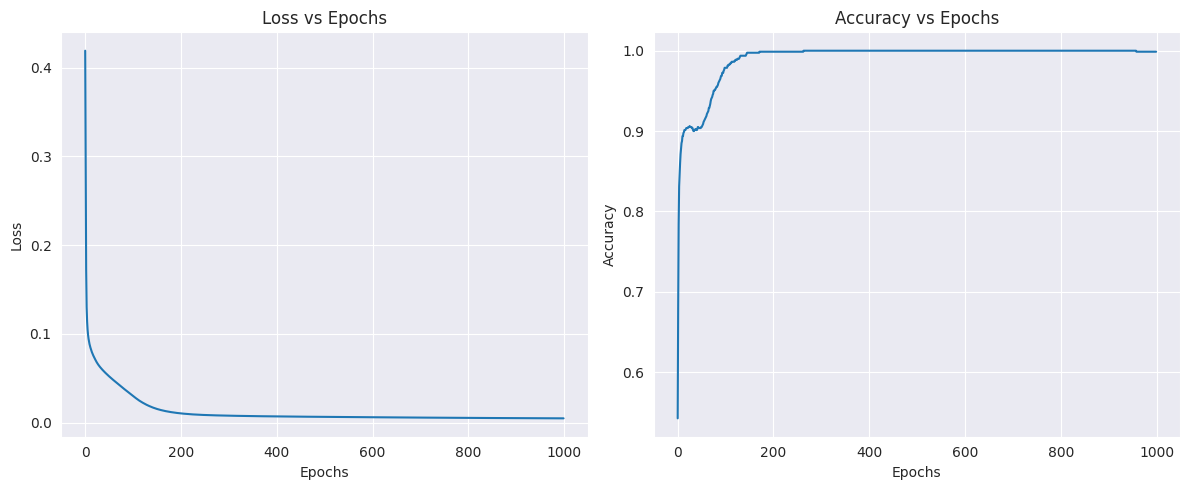

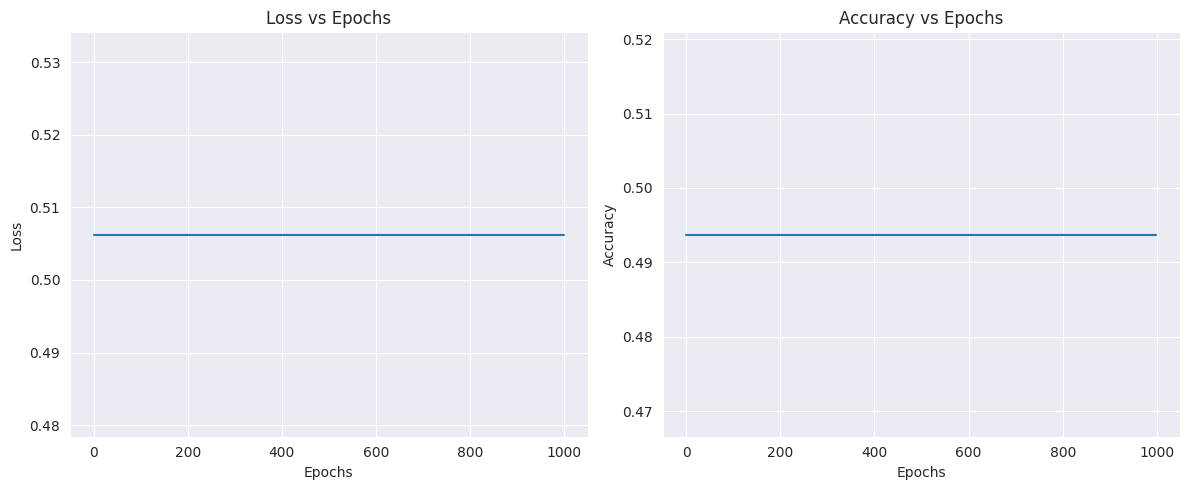

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_losses(history: Dict[str, List[float]]) -> None:
    sns.set_style("darkgrid")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history["accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.tight_layout()
    plt.show()


plot_losses(history_moons)
plot_losses(history_circles)

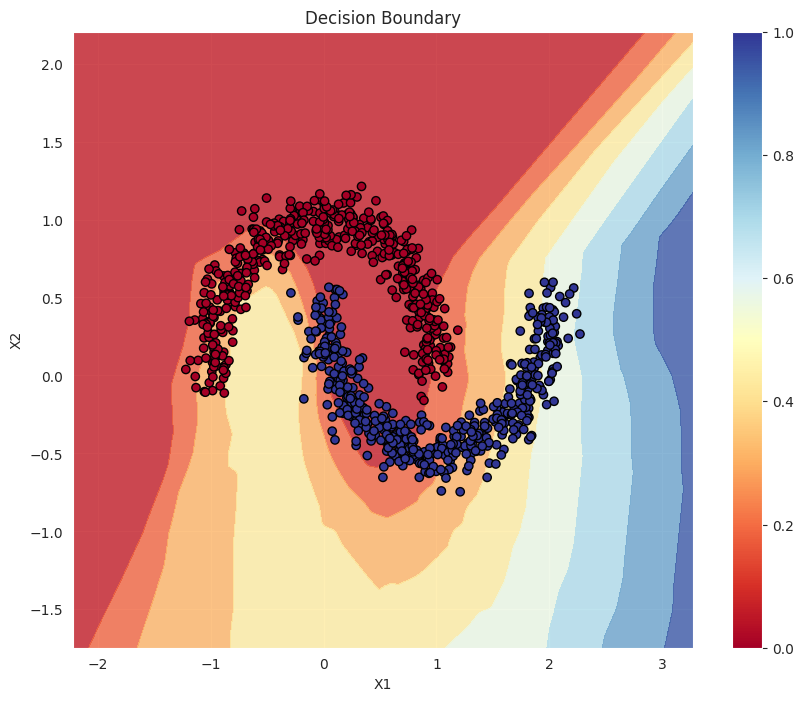

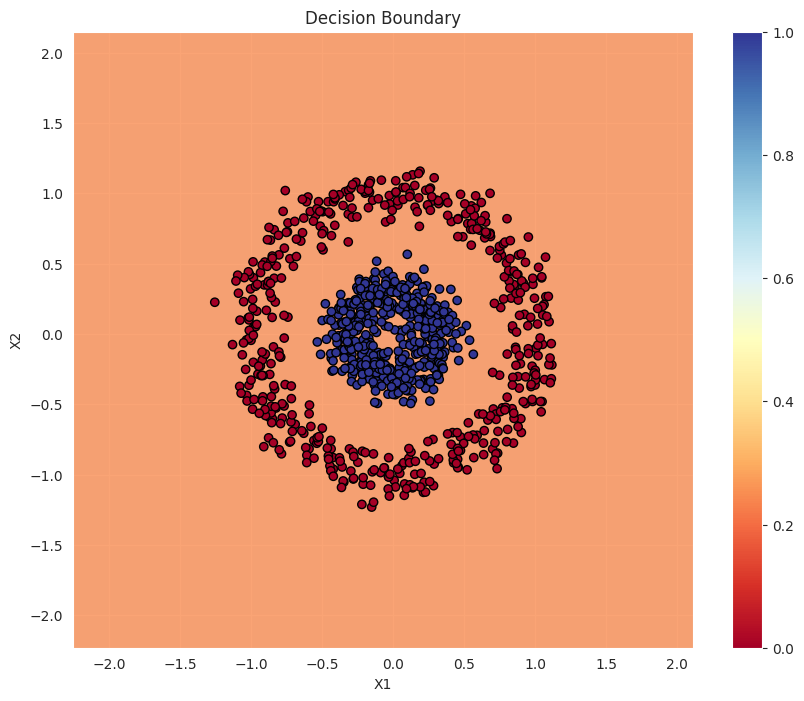

In [9]:
def plot_decision_boundary(
    X: np.ndarray, y: np.ndarray, model: NeuralNetwork, h: float = 0.01
) -> None:
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap=plt.cm.RdYlBu, edgecolors="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Decision Boundary")
    plt.colorbar()
    plt.show()


plot_decision_boundary(X_moons, y_moons, nn_moons)
plot_decision_boundary(X_circles, y_circles, nn_circles)